<figure>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Diplomado-Avanzado/main/Programación/Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Taller de torchvision en clasificación de imagenes</center></span>
# <span style="color:red"><center>Dataset CIFAR</center></span>

## <span style="color:blue">Autores</span>

* Nayibe Yesenia Arias, naariasc@unal.edu.co

## <span style="color:blue">Profesores</span>

- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Campo Elías Pardo, PhD, cepardot@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, ojarmam@unal.edu.co

##   <span style="color:blue">Asesora Medios y Marketing digital</span>

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## ¿Qué es CIFAR?

Es una colección de imágenes que se usan para entrenar algoritmos de aprendizaje automático y visón por computadora. 
Detalles:
* 32x32x3, en espacio RGB
* 50.000 imágenes de entrenamiento
* 10.000 imágenes de prueba
* 10 clases:
    * avión
    * automovil
    * ave
    * gato
    * venado
    * perro
    * rana
    * caballo
    * camión
    * barco

Para definir un clasificador de imagenes haremos los siguientes pasos:

1. Carga y normaliza los conjuntos de datos de entrenamiento y prueba CIFAR10 usando ```torchvision```
2. Definir una red neuronal convolucional
3. Definir una función de pérdida
4. Capacitar a la red en los datos de formación
5. Probar la red en los datos de prueba

## 1. Importar librerías

In [1]:
import torch
import numpy as np
from torchvision import datasets

## 2. Elegir usar CPU o GPU


Como se trata de imágenes grandes (32x32x3), usamos GPU para entrenar nuestro modelo más eficientemente.

Para que Pytorch reconozca la Tarjeta gráfica, es necesario descargar una versión de `cudatoolkit` y, opcionalmente, `cudnn`.

In [2]:
import torch
import numpy as np

# comprobar si CUDA está disponible
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA no está disponible. Entrenando en CPU ...')
else:
    print('¡CUDA está disponible! Entrenando en GPU ...')

¡CUDA está disponible! Entrenamiento en GPU ...


## 3. cargar el dataset CIFAR10

A continuación cargamos el conjunto de datos CIFAR10


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# número de subprocesos a utilizar para la carga de datos
num_workers = 0
# cuantas muestras por lote cargar
batch_size = 20
# porcentaje del conjunto de entrenamiento para usar como validación
valid_size = 0.2

# convertir datos a un normalizada torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# elegir los conjuntos de datos de entrenamiento y prueba
train_data = datasets.CIFAR10('/mnt/storage/Datasets/', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('/mnt/storage/Datasets/', train=False,
                             download=True, transform=transform)

# obtener índices de entrenamiento que se utilizarán para la validación
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# definir muestreadores para obtener lotes de entrenamiento y validación
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparar cargadores de datos (combinar conjunto de datos y muestra)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# especificar las clases de imagen
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /mnt/storage/Datasets/cifar-10-python.tar.gz to /mnt/storage/Datasets/
Files already downloaded and verified


## 4. Revisar el dataset

Visualizamos los datos para comprender mejor los datos.

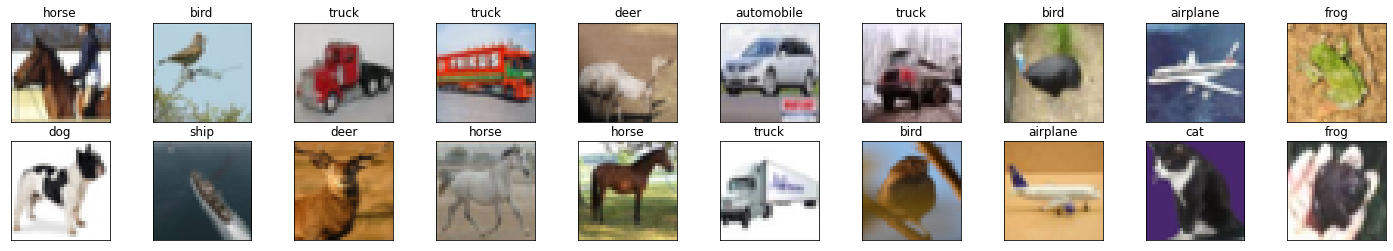

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# función auxiliar para desnormalizar y mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convertir de tensor a imagen

# obtener un lote de imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convertir imágenes a numpy para mostrar
# dibuja las imágenes en el lote, junto con las etiquetas correspondientes
fig = plt.figure(figsize=(25, 4))
# muestra 20 imagenes
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])


Podemos tratar de ver las imágenes con más detalle. Aquí, vemos los canales de color rojo, verde y azul normalizados (RGB) como tres imágenes separadas de intensidad en escala de grises.


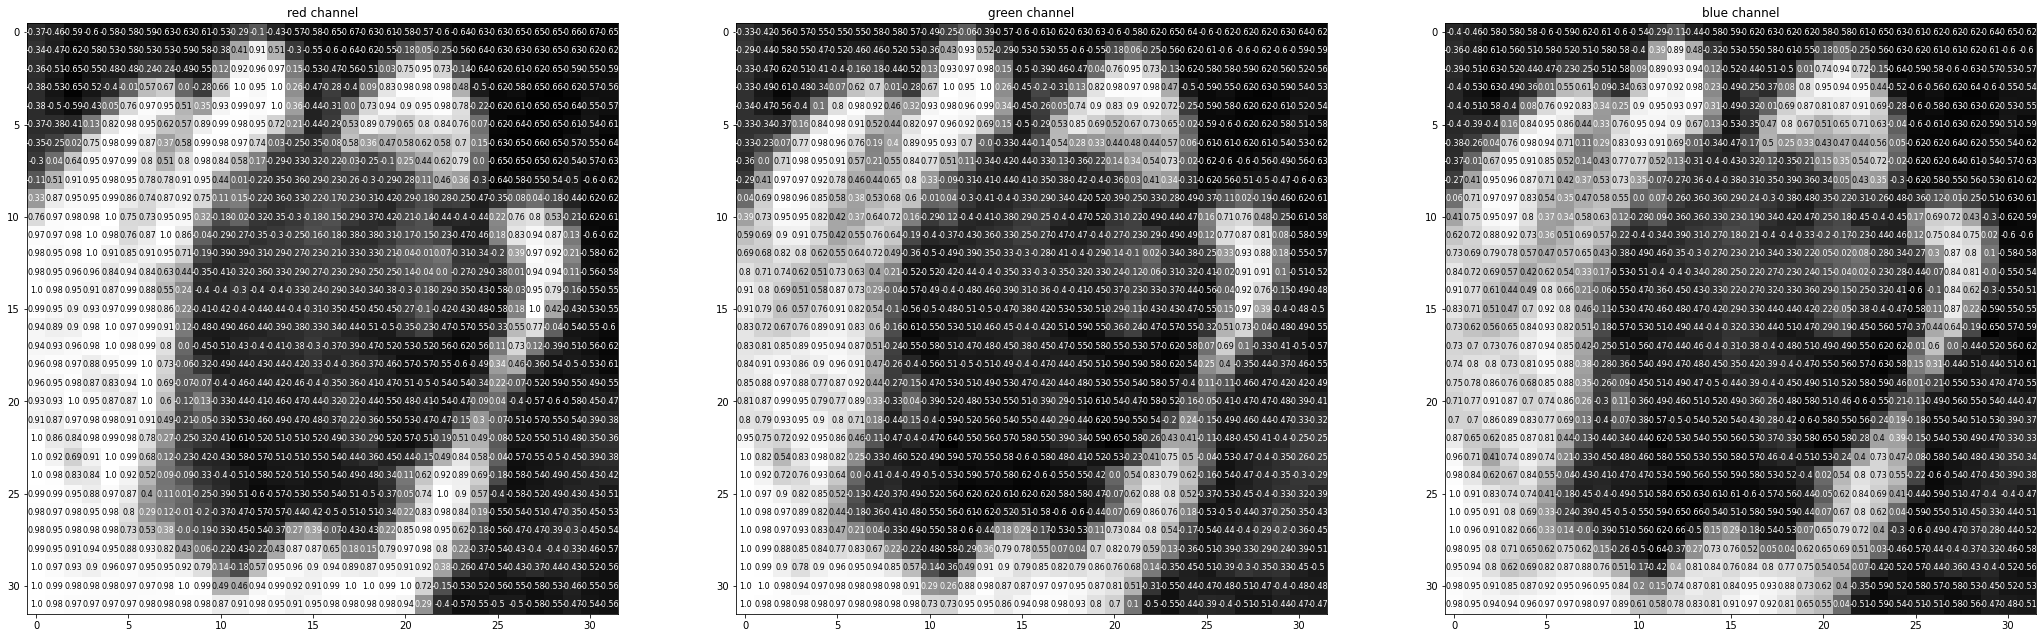

In [6]:
rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## 5. Definir el modelo


**Importante:** En Pytorch, es necesario calcular manualmente los valores de entrada y salida de las capas y conexiones de una red. Para calcular el tamaño de salida de una capa convolucional dada, podemos realizar el siguiente cálculo:

Suponiendo las siguientes variables: 
* Tamaño del volumen de entrada ($W$)
* El tamaño del kernel ($F$)
* La zancada (stride) con la que se aplican ($S$)
* la cantidad de relleno (padding) utilizado ($P$) en la frontera. 

La fórmula correcta para calcular cuántas neuronas definen la salida_W está dada por $(W−F+2P)/(S+1).$

Ejemplo: 
Supongamos que

* El tamaño de la imagen de entrada es uniformemente 227 x 227 x 3 (alto x ancho x número de canales de color), $W=227$ 
* El tamaño de cada núcleo de convolución es 11 x 11 x 3, $F=11$
* stride $S= 4$
* padding $P = 0$,


Entonces la altura / anchura de la matriz de salida es $(227-11) / 4 + 1 = 55$

In [7]:
import torch.nn as nn
import torch.nn.functional as F


### modelo inicial

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) #(canales de entrada, canales de salida, tamaño del kernel)
    self.pool = nn.MaxPool2d(2, 2) #(Tamaño del kernel, stride)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    
# crear una CNN completa
model = Net()
print(model)
# mover tensores a GPU si CUDA está disponible
if train_on_gpu:
  model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 6. Función de pérdida y optimizador

### Función de perdida

Esta nos ayuda a calcular la diferencia entre la salida real y la variable objetivo, con la intención de evaluar correctamente el desempeño del modelo. En este caso usaremos Entropía cruzada, la cual se utiliza en casos de comparar probabilidades.
 


### Optimizador

Con esta función se actualizan los pesos de la red.Aquí utilizaremos el optimizador SGD (Stochastic Gradient Descent). El descenso de gradiente nos ayuda a reducir las pérdidas con el tiempo. Esto está muy influenciado por la tasa de aprendizaje. La tasa de aprendizaje nos ayuda a la rapidez con la que el modelo converge a la solución. Aquí hemos elegido un valor de 0,01

In [9]:
import torch.optim as optim
# Especifica funcion de perdidas
criterion = nn.CrossEntropyLoss()
# Especifica optimizador
optimizer = optim.SGD(model.parameters(), lr=.01)

## 7. Entrenamiento

Ahora entrenamos nuestro modelo usando el conjunto de validación. Se usa para ver cómo funciona nuestro modelo antes de usar el conjunto de prueba real.

Necesitamos echar un vistazo de cerca a nuestras pérdidas de conjuntos de validación. Si las pérdidas aumentan entonces es un caso de overfitting

In [10]:
# número de epochs para entrenar el modelo
n_epochs = 30
# Lista para almacenar pérdidas, para visualizar
train_losslist = []
valid_loss_min = np.Inf # realizar un seguimiento del cambio en la pérdida de validación

for epoch in range(1, 30):

    # Realizar un seguimiento del cambio en la pérdida de validación
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Entrena el modelo #
    ###################
    model.train()
    for data, target in train_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # borrar los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcule las salidas predichas pasando las entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
        loss.backward()
        # realizar un único paso de optimización (actualización de parámetros)
        optimizer.step()
        # actualizar pérdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validar el modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # actualizar la pérdida de validación promedio 
        valid_loss += loss.item()*data.size(0)
    
    # calcular pérdidas promedio
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # imprimir estadísticas de entrenamiento/validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # guarde el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print('Perdida en validación reducida ({:.6f} --> {:.6f}).  Guardando modelo ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.786693 	Validation Loss: 0.414621
Validation loss decreased (inf --> 0.414621).  Saving model ...
Epoch: 2 	Training Loss: 1.519100 	Validation Loss: 0.342640
Validation loss decreased (0.414621 --> 0.342640).  Saving model ...
Epoch: 3 	Training Loss: 1.284947 	Validation Loss: 0.298171
Validation loss decreased (0.342640 --> 0.298171).  Saving model ...
Epoch: 4 	Training Loss: 1.172698 	Validation Loss: 0.282210
Validation loss decreased (0.298171 --> 0.282210).  Saving model ...
Epoch: 5 	Training Loss: 1.094595 	Validation Loss: 0.262667
Validation loss decreased (0.282210 --> 0.262667).  Saving model ...
Epoch: 6 	Training Loss: 1.034458 	Validation Loss: 0.250470
Validation loss decreased (0.262667 --> 0.250470).  Saving model ...
Epoch: 7 	Training Loss: 0.986332 	Validation Loss: 0.243889
Validation loss decreased (0.250470 --> 0.243889).  Saving model ...
Epoch: 8 	Training Loss: 0.942974 	Validation Loss: 0.236318
Validation loss decreased (0.24388

### Gráfico loss vs epoch

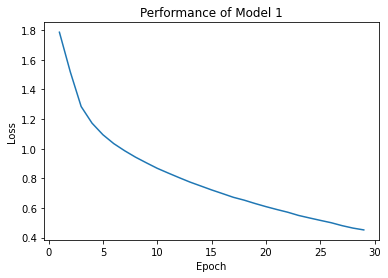

In [11]:
plt.plot([*range(1,30)], train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

## 8. probando la red en un conjunto de datos

In [ ]:
# track test loss (Seguimiento de pérdida de prueba)
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre datos de prueba
for data, target in test_loader:
    # mover tensores a GPU si CUDA está disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: calcular las salidas predichas pasando entradas al modelo
    output = model(data)
    # calcular la pérdida del lote(batch)
    loss = criterion(output, target)
    # actualización de pérdida de prueba 
    test_loss += loss.item()*data.size(0)
    # convertir las probabilidades de salida a la clase predicha
    _, pred = torch.max(output, 1)    
    # comparar predicciones con la etiqueta(label) verdadera
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular la precisión de la prueba para cada clase de objeto
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# pérdida de prueba promedio
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.314929

Test Accuracy of airplane: 69% (693/1000)
Test Accuracy of automobile: 73% (731/1000)
Test Accuracy of  bird: 40% (402/1000)
Test Accuracy of   cat: 45% (457/1000)
Test Accuracy of  deer: 65% (651/1000)
Test Accuracy of   dog: 40% (404/1000)
Test Accuracy of  frog: 67% (674/1000)
Test Accuracy of horse: 68% (681/1000)
Test Accuracy of  ship: 70% (700/1000)
Test Accuracy of truck: 74% (741/1000)

Test Accuracy (Overall): 61% (6134/10000)


# Mejoras

## Cambiando el modelo

incrementaremos la cantidad de capas, añadiremos bloques convolucionales que tienen un tamaño de núcleo de 3. 
Un núcleo es un filtro que se utiliza para extraer características de las imágenes. 

También cambiaremos el tamaño de los canales.

In [12]:
class CNN(nn.Module):
   

    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x



#_______________________________________________________________________
#VER COMO CONSTRUÍ LA RED:

# Crear una cnn completa
model = CNN()
print(model)
# mover tensores a GPU si CUDA está disponible
if train_on_gpu:
  model.cuda()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Lo siguiente que haremos es cambiar la tasa de aprendizaje de 0,01 a 0,001 para que nuestro modelo converja más gradualmente.

## Cambiando la funcion de perdida y optimizador

In [13]:
import torch.optim as optim
# Especificar funcion de perdidas
criterion = nn.CrossEntropyLoss()
# especificar optimizador
optimizer = optim.SGD(model.parameters(), lr=.001)

# Entrenando nuevamente

In [14]:
# número de epochs para entrenar el modelo
n_epochs = 30
#Lista para almacenar pérdida para visualizar
train_losslist = []
valid_loss_min = np.Inf # realizar un seguimiento del cambio en la pérdida de validación

for epoch in range(1, 30):

    # hacer un seguimiento de la pérdida de entrenamiento y validación
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Entrena al modelo #
    ###################
    model.train()
    for data, target in train_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # limpia(clear) los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
        loss.backward()
        # realizar un único paso de optimización (actualización de parámetros)
        optimizer.step()
        # actualizar pérdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Valida el modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # actualizar la pérdida de validación promedio 
        valid_loss += loss.item()*data.size(0)
    
    # calcular pérdidas promedio
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # imprimir estadísticas de entrenamiento/validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # guarde el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.766443 	Validation Loss: 0.390122
Validation loss decreased (inf --> 0.390122).  Saving model ...
Epoch: 2 	Training Loss: 1.394205 	Validation Loss: 0.309438
Validation loss decreased (0.390122 --> 0.309438).  Saving model ...
Epoch: 3 	Training Loss: 1.208598 	Validation Loss: 0.271443
Validation loss decreased (0.309438 --> 0.271443).  Saving model ...
Epoch: 4 	Training Loss: 1.084645 	Validation Loss: 0.247007
Validation loss decreased (0.271443 --> 0.247007).  Saving model ...
Epoch: 5 	Training Loss: 0.980666 	Validation Loss: 0.224976
Validation loss decreased (0.247007 --> 0.224976).  Saving model ...
Epoch: 6 	Training Loss: 0.889204 	Validation Loss: 0.203068
Validation loss decreased (0.224976 --> 0.203068).  Saving model ...
Epoch: 7 	Training Loss: 0.812545 	Validation Loss: 0.189881
Validation loss decreased (0.203068 --> 0.189881).  Saving model ...
Epoch: 8 	Training Loss: 0.744528 	Validation Loss: 0.184711
Validation loss decreased (0.18988

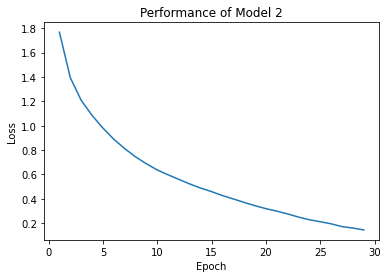

In [15]:
plt.plot([*range(1,30)], train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 2")
plt.show()

Revisamos el nuevo modelo con los datos de prueba.

In [16]:
# track test loss (Seguimiento de pérdida de prueba)
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre datos de prueba
for data, target in test_loader:
    # mover tensores a GPU si CUDA está disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: calcular las salidas predichas pasando entradas al modelo
    output = model(data)
    # calcular la pérdida del lote(batch)
    loss = criterion(output, target)
    # actualización de pérdida de prueba 
    test_loss += loss.item()*data.size(0)
    # convertir las probabilidades de salida a la clase predicha
    _, pred = torch.max(output, 1)    
    # comparar predicciones con la etiqueta(label) verdadera
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular la precisión de la prueba para cada clase de objeto
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# pérdida de prueba promedio
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.848141

Test Accuracy of airplane: 78% (784/1000)
Test Accuracy of automobile: 88% (886/1000)
Test Accuracy of  bird: 64% (641/1000)
Test Accuracy of   cat: 60% (601/1000)
Test Accuracy of  deer: 56% (564/1000)
Test Accuracy of   dog: 79% (791/1000)
Test Accuracy of  frog: 79% (794/1000)
Test Accuracy of horse: 78% (786/1000)
Test Accuracy of  ship: 88% (883/1000)
Test Accuracy of truck: 88% (886/1000)

Test Accuracy (Overall): 76% (7616/10000)
